Import Packages

In [1241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
df = pd.read_csv("./audi.csv")
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


In [1242]:
df["num_owners"] = df["mileage"].apply(lambda x: "First" if x < 10000 else ("Second" if x > 10000 and x < 25000 else "Third"))
df["crashed"] = df["mileage"].apply(lambda x: "Yes" if x > 30000 else "No")
df["car_age"] = 2025 - df["year"]
df["mileage_per_year"] = df["mileage"] / df["car_age"]

df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,num_owners,crashed,car_age,mileage_per_year
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Second,No,8,1966.875000
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,Third,Yes,9,4022.555556
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Third,No,9,3327.333333
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,Third,No,8,3244.000000
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,First,No,6,333.000000
5,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4,Third,Yes,9,3584.444444
6,A6,2016,13250,Automatic,76788,Diesel,30,61.4,2.0,Third,Yes,9,8532.000000
7,A4,2016,11750,Manual,75185,Diesel,20,70.6,2.0,Third,Yes,9,8353.888889
8,A3,2015,10200,Manual,46112,Petrol,20,60.1,1.4,Third,Yes,10,4611.200000
9,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4,Second,No,9,2494.555556


Detect outliers

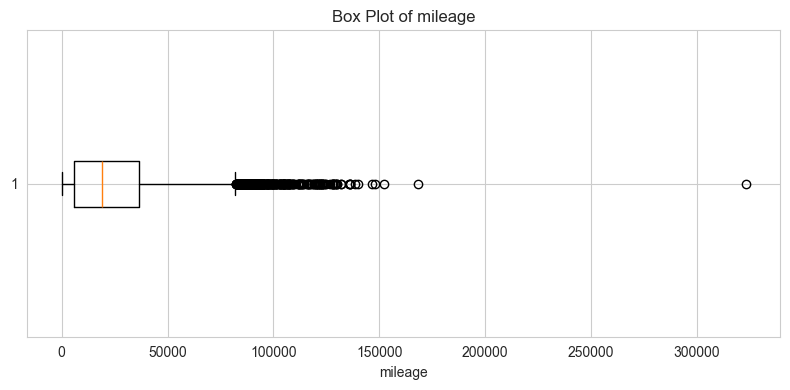

In [1243]:
plt.figure(figsize=(8, 4))
plt.boxplot(df['mileage'], vert=False)
plt.title("Box Plot of mileage")
plt.xlabel("mileage")
plt.tight_layout()
plt.show()

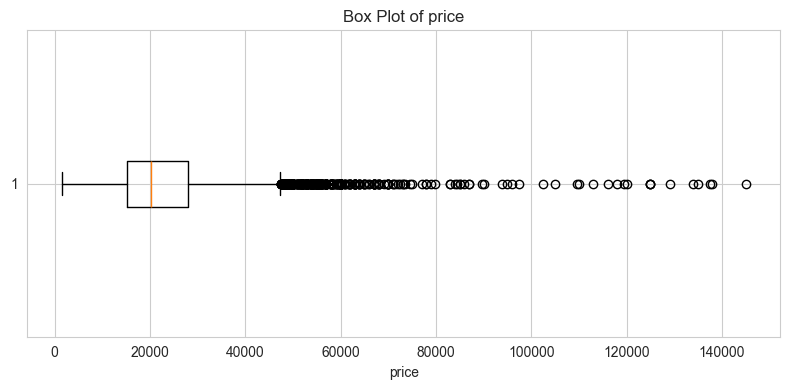

In [1244]:
plt.figure(figsize=(8, 4))
plt.boxplot(df['price'], vert=False)
plt.title("Box Plot of price")
plt.xlabel("price")
plt.tight_layout()
plt.show()

Filter Outliers

In [1245]:
Q1 = df[['mileage', 'price']].quantile(0.25) 
Q3 = df[['mileage', 'price']].quantile(0.75)  
IQR = Q3 - Q1 
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
outliers = ((df[['mileage', 'price']] < lower_bound) | (df[['mileage', 'price']] > upper_bound)).sum()
print(outliers)
df = df[(df['price'] >= lower_bound['price']) & (df['price'] <= upper_bound['price'])]

mileage    132
price      243
dtype: int64


Plots

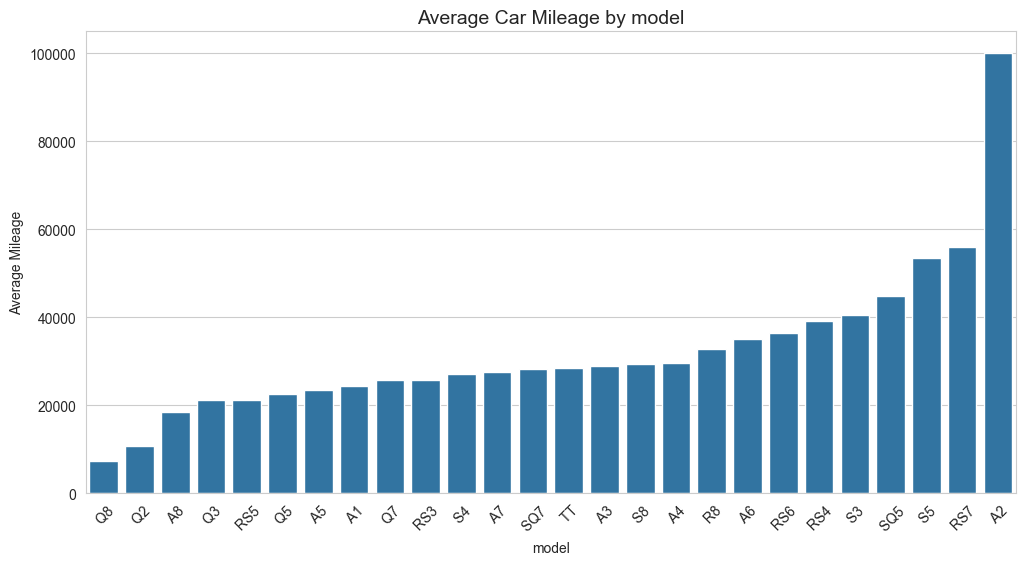

In [1246]:
plt.figure(figsize=(12, 6))
model_avg_mileage = df.groupby("model")["mileage"].mean().sort_values()
sns.barplot(x=model_avg_mileage.index, y=model_avg_mileage.values)
plt.xticks(rotation=45)
plt.title("Average Car Mileage by model", fontsize=14)
plt.xlabel("model")
plt.ylabel("Average Mileage")
plt.show()

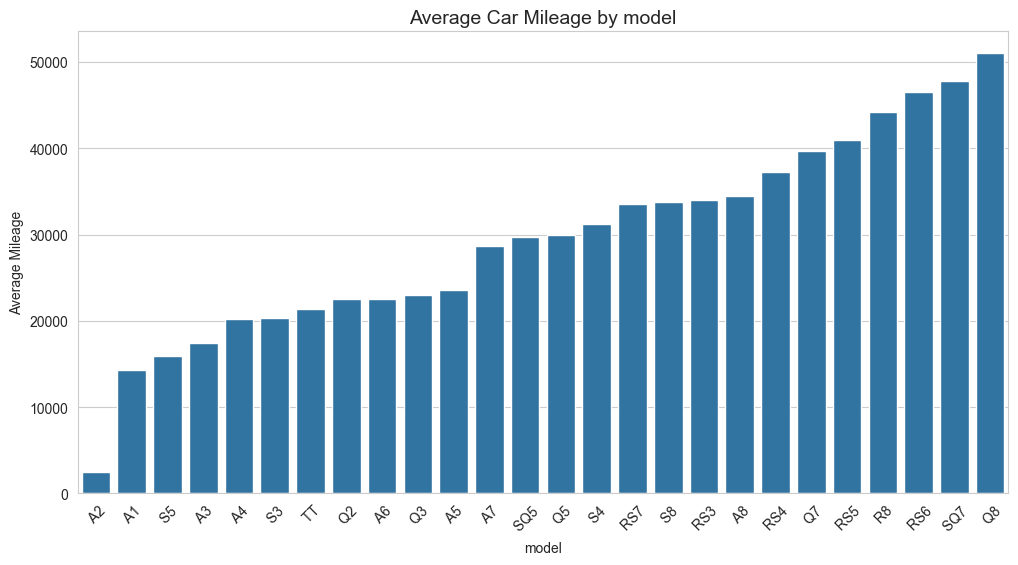

In [1247]:
plt.figure(figsize=(12, 6))
model_avg_mileage = df.groupby("model")["price"].mean().sort_values()
sns.barplot(x=model_avg_mileage.index, y=model_avg_mileage.values)
plt.xticks(rotation=45)
plt.title("Average Car Mileage by model", fontsize=14)
plt.xlabel("model")
plt.ylabel("Average Mileage")
plt.show()

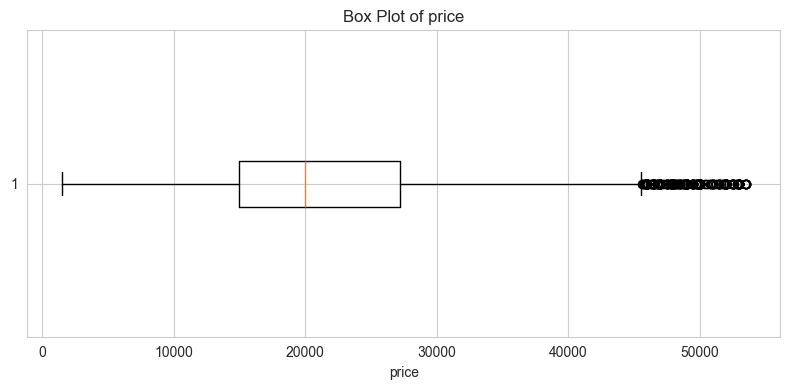

In [1248]:
plt.figure(figsize=(8, 4))
plt.boxplot(df['price'], vert=False)
plt.title("Box Plot of price")
plt.xlabel("price")
plt.tight_layout()
plt.show()

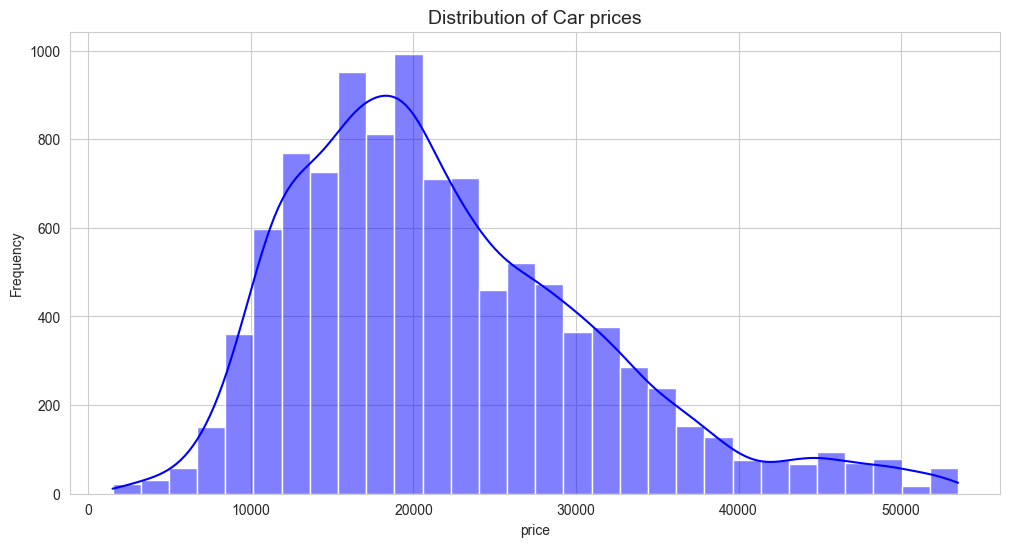

In [1249]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True, color="blue")
plt.title("Distribution of Car prices", fontsize=14)
plt.xlabel("price")
plt.ylabel("Frequency")
plt.show()

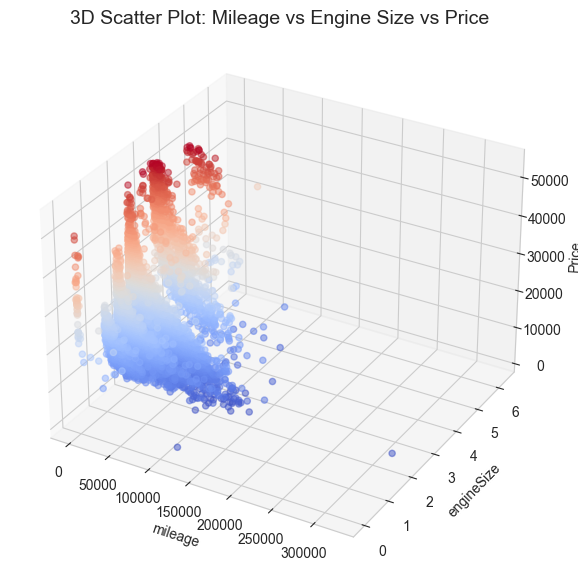

In [1250]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['mileage'], df['engineSize'], df['price'], alpha=0.5, c=df['price'], cmap='coolwarm')
ax.set_xlabel("mileage")
ax.set_ylabel("engineSize")
ax.set_zlabel("Price")
ax.set_title("3D Scatter Plot: Mileage vs Engine Size vs Price", fontsize=14)
plt.show()

New Features

Label Encoding

In [1251]:
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,num_owners,crashed,car_age,mileage_per_year
0,0,2017,12500,1,15735,2,150,55.4,1.4,1,0,8,1966.875000
1,5,2016,16500,0,36203,0,20,64.2,2.0,2,1,9,4022.555556
2,0,2016,11000,1,29946,2,30,55.4,1.4,2,0,9,3327.333333
3,3,2017,16800,0,25952,0,145,67.3,2.0,2,0,8,3244.000000
4,2,2019,17300,1,1998,2,145,49.6,1.0,0,0,6,333.000000


Correlation

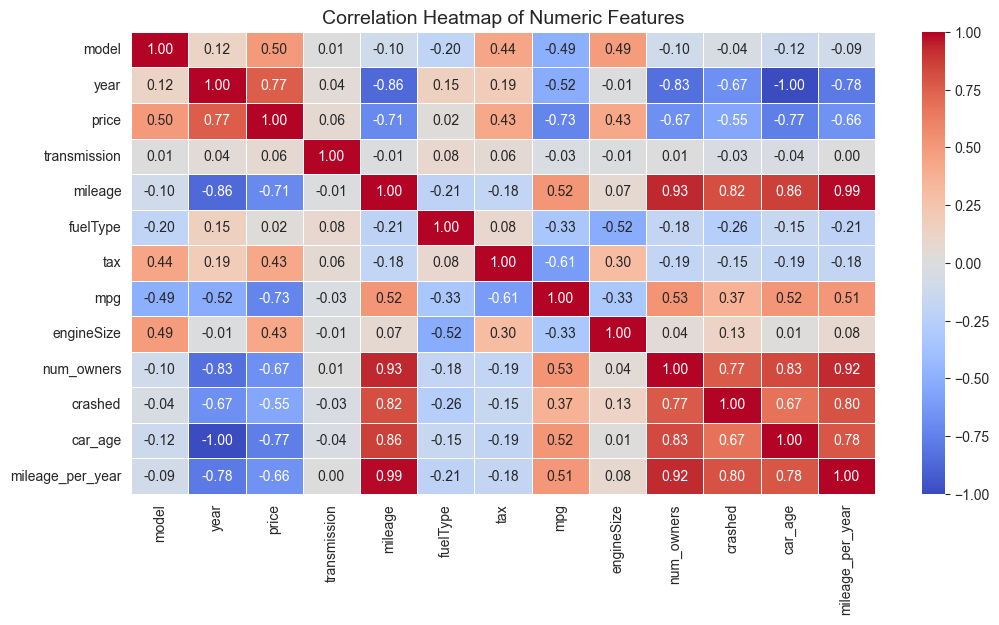

In [1252]:
plt.figure(figsize=(12, 6))
corr_matrix = df.corr(numeric_only = True, method="spearman")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

Train Test Split

In [1253]:
X = df.drop(columns=["price"])
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Score

In [1254]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, RMSE: {rmse}, R2 Score: {r2}')

MAE: 1512.6849396247976, RMSE: 2147.5604284361575, R2 Score: 0.9491084556355422


Actual vs Prediction

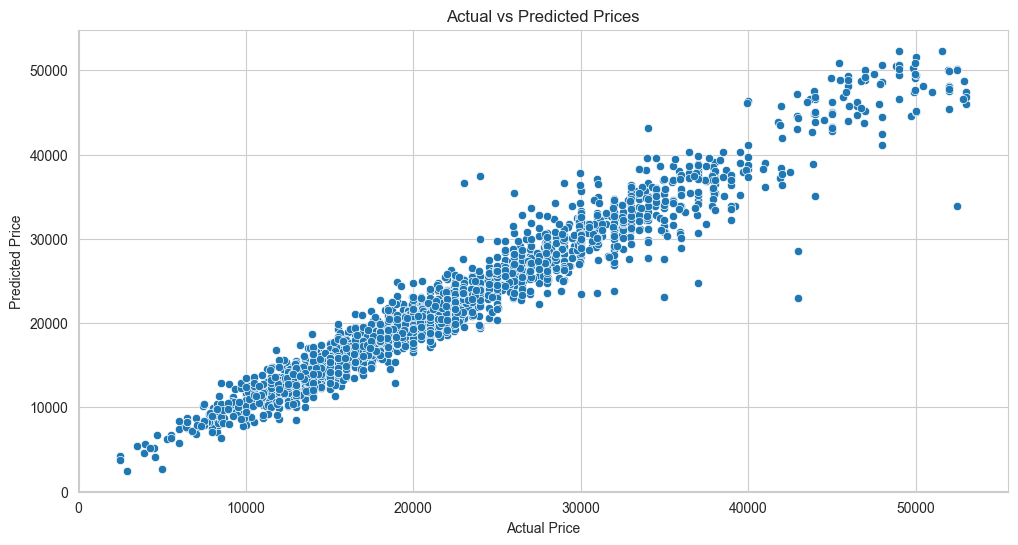

In [1255]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()

Predicting Crash

In [1256]:
X = df.drop(columns=["crashed"])
y = df["crashed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, RMSE: {rmse}, R2 Score: {r2}')

MAE: 0.00047961630695443646, RMSE: 0.02190014399392014, R2 Score: 0.9978274777694188


Performance

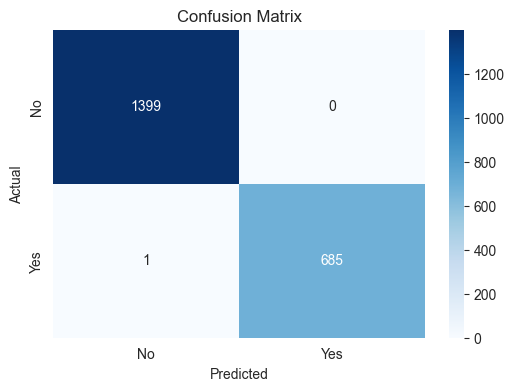

In [1257]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()